# sklearn.linear_model.SGDClassifier

In [1]:
import xml.etree.ElementTree as ET
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score


# XML Reading function

In [2]:

def parse_xml_to_dict(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    data_dict = {}
    for doc in root.findall('doc'):
        text_parts = []
        for p in doc.find('texte').findall('p'):
            if p.text:
                text_parts.append(p.text)
        
        text = ' '.join(text_parts)
        label = doc.find('.//PARTI').attrib['valeur']
        doc_id = doc.attrib['id']
        
        data_dict[doc_id] = (text, label)
    
    return data_dict

train_en = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_en.xml")
train_fr = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_fr.xml")
train_it = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_it.xml")


# Crééation d'un dico TEST (données avec une structure différente)

In [3]:
def parse_xml_and_labels(xml_file, labels_file):
    test_labels_dict = {}
    with open(labels_file, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                doc_id = parts[0]
                label = parts[1]
                test_labels_dict[doc_id] = label
            #else:
                #print('There is no class label for : ', line, str(labels_file.split('.')[-2]))
    
    def parse_xml_to_dict(file_path):
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data_dict = {}
        for doc in root.findall('doc'):
            text_parts = []
            for p in doc.find('texte').findall('p'):
                if p.text:
                    text_parts.append(p.text)
            
            text = ' '.join(text_parts)
            doc_id = doc.attrib['id']
            
            data_dict[doc_id] = text
        
        return data_dict
    
    test_dict = parse_xml_to_dict(xml_file)
    final_test_data = {}
    for doc_id, text in test_dict.items():
        if doc_id in test_labels_dict:
            label = test_labels_dict[doc_id]
            final_test_data[doc_id] = (text, label)
    
    return final_test_data


In [4]:
test_en = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_en.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_en.txt")
len(test_en)

test_fr = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_fr.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_fr.txt")
len(test_fr)

test_it = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_it.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_it.txt")
len(test_it)

12915

# Algo SGDClassifier

In [5]:
# Joining dics 
combined_train_data = {**train_en, **train_fr, **train_it}
combined_test_data = {**test_en, **test_fr, **test_it}


# Dividing texts and labels 
train_texts, train_labels = zip(*combined_train_data.values())
test_texts, test_labels = zip(*combined_test_data.values())

# Initializing the model SGDClassifier using the  Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(max_iter=1000, loss="modified_huber", n_jobs=-1, learning_rate="optimal")),
])

# Training the model
text_clf.fit(train_texts, train_labels)


accuracy = text_clf.score(test_texts, test_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7671285902299295


In [6]:
vectorized_train_texts = text_clf.named_steps['vect'].transform(train_texts)
vectorized_test_texts = text_clf.named_steps['vect'].transform(test_texts)


# Playing with the model

In [7]:
# Getting all classes of the model
unique_labels = text_clf.named_steps['clf'].classes_
print(f"All unique labels: {unique_labels}")

All unique labels: ['ELDR' 'GUE-NGL' 'PPE-DE' 'PSE' 'Verts-ALE']


In [8]:
new_text = "Omg Je veux te voir Dans un film pornographique En action avec ta bite"
predicted_label = text_clf.predict([new_text])

print(f"Predicted label for the text: {predicted_label[0]}")

Predicted label for the text: GUE-NGL


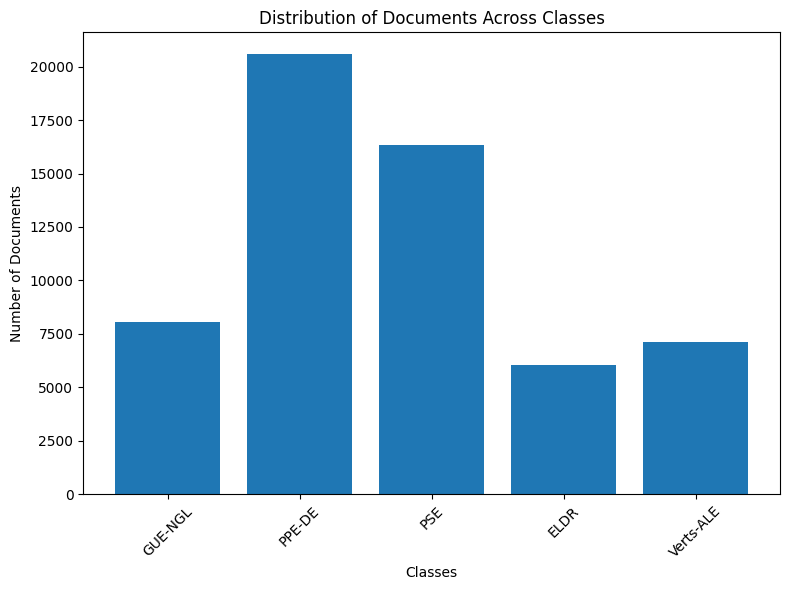

In [9]:
# Distribution of Documents Across Classes

class_counts = {}
for doc_tuple in combined_train_data.values():
    label = doc_tuple[1]  
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Classes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


In [15]:
combined_train_data

{'2_en:1': ('Heralded as ‘a stage further in the opening of postal services to competition’, the Council wants the European Parliament to approve a directive which constitutes another step towards doing away with the public postal service. The policy of the national governments and the European institutions is a reactionary policy that is harmful both to users and to workers of this sector, which is faced with further job losses. We reject the Council’s draft text, which serves the interests of private companies that will share between themselves the profitable sectors of the postal services and leave the public sector with the scraps that are incapable of properly fulfilling social needs. We also reject the compromise amendments that are designed to mask the hypocrisy and our capitulation before private interests. We would like to reiterate that postal services must remain a public service, to which everyone has access under the same conditions, whatever their location and whatever th

# Kernal approximation

In [14]:
train_texts, train_labels = zip(*combined_train_data.values())
test_texts, test_labels = zip(*combined_test_data.values())

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('rbf_sampler', RBFSampler(gamma=1, random_state=1)),  # Applying RBFSampler for kernel approximation
    ('clf', SGDClassifier(max_iter=1000)),
])


text_clf.fit(train_texts, train_labels)
test_predictions = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy}")



Accuracy: 0.3489200278702485
